In [67]:
import sys
sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from analysis.information import AdaptationChannel
from multiprocessing import Pool, cpu_count
import os
import pickle

publication_directory = '../manuscript'

neurons = ['RS','IB','FS','CH']
tw = 500

res_df = pd.read_pickle('../data/transition_rates.pkl')

def get_cost_capacity(neuron):
    filename = f'{neuron}_capacity_cost_fine.pkl'
    if filename in os.listdir('saved_functions'):
        with open(f'saved_functions/{filename}', 'rb') as file:
            func = pickle.load(file)
    else:
        func = AdaptationChannel(res_df.loc[0, tw, neuron]).cost_capacity(min_rate=5, resolution_points=30)

        with open(f'saved_functions/{filename}', 'wb') as file:
            pickle.dump(func, file)
    
    return func

In [69]:
import matplotlib.gridspec as gridspec

In [52]:
from scipy.interpolate import UnivariateSpline

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


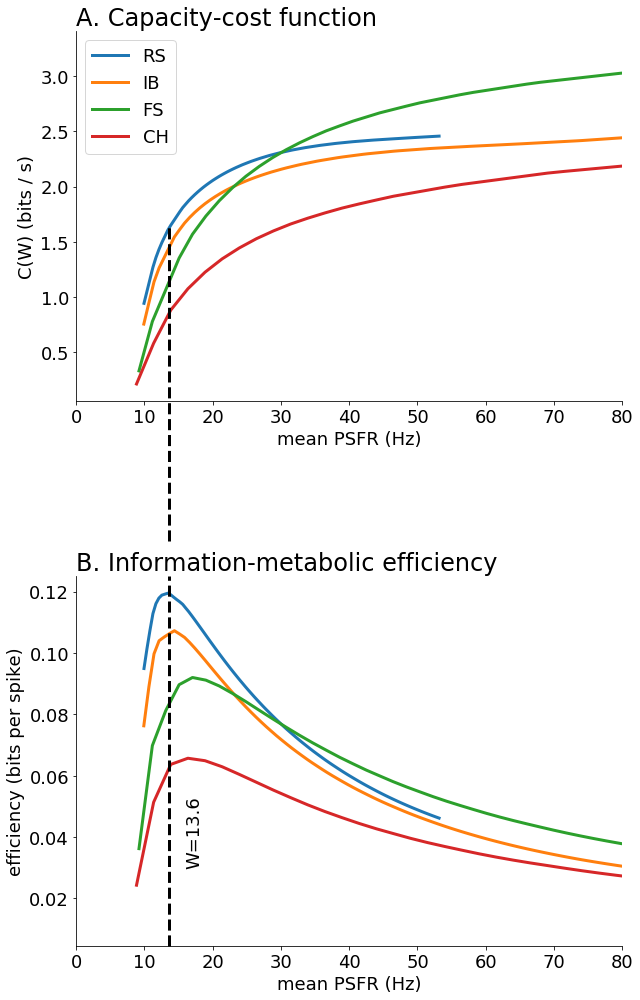

In [71]:

cost_capacities = pd.Series({neuron: get_cost_capacity(neuron) for neuron in neurons})
fig, axes = plt.subplots(tight_layout=True, figsize=(9,14), nrows=2)

# CAPACITY-COST

ax1 = axes[0]
ax2 = axes[1]

for i, neuron in enumerate(neurons):
    cost_capacities[neuron]['W'] = cost_capacities[neuron]['W'] * 1000 / tw
    ser = cost_capacities[neuron].set_index('W').sort_index()
    x = ser.index.get_level_values(0).values
    y = ser['C'].values
    f = UnivariateSpline(x, y, s=0, k=1)
    x_arr = np.linspace(x.min(),x.max(), 100)
    ax1.plot(x_arr, f(x_arr), lw=3, label=neuron)
    ax2.plot(x_arr, f(x_arr) / x_arr, lw=3)
#     cost_capacities[neuron].set_index('W').sort_index()['C'].plot(ax=ax1, c=f'C{i}', lw=3, label=neuron)
#     cost_capacities[neuron].set_index('W').sort_index()['C/W'].plot(ax=ax2, c=f'C{i}', lw=3)
    
#     maxloc = cost_capacities[neuron]['C/W'].argmax()
#     best = cost_capacities[neuron].loc[maxloc]
#     axes[0].axvline(best['W'], c=f'C{i}')

ax1.legend()
ax1.set_xlim(0,40 * 1000 / tw)
ax2.set_xlim(0,40 * 1000 / tw)
# axes[0].grid()
# axes[1].grid()
ax1.set_xlabel('mean PSFR (Hz)')
ax2.set_xlabel('mean PSFR (Hz)')

ax1.set_title('A. Capacity-cost function', loc='left', fontsize=24)
ax1.set_ylabel('C(W) (bits / s)')

ax2.set_title('B. Information-metabolic efficiency', loc='left', fontsize=24)
ax2.set_ylabel('efficiency (bits per spike)')

for side in ['right','top']:
    ax1.spines[side].set_visible(False)
    ax2.spines[side].set_visible(False)

# RS cara
c, cw, w = cost_capacities['RS'].sort_values('C/W').iloc[-1]
ylims = ax1.get_ylim()
ax1.axvline(w, -0.38, c / ylims[1], lw=3, linestyle='dashed', clip_on=False, c='black')
ax2.axvline(w, 0, 1, lw=3, linestyle='dashed', clip_on=False, c='black')
ax2.text(x=16, y=0.03, s=f'W={w:.1f}', rotation=90, fontsize=18, va='bottom')
# ax2.axvline(20, 0, 2, clip_on=False)


plt.savefig(f'{publication_directory}/img/cost_capacity.pdf', bbox_inches='tight')